# # Machine Learning Pipeline: Image Classification

# This notebook demonstrates the end-to-end process for an image classification task,
# including data loading, preprocessing, model training, and evaluation.

In [1]:
# ## 1. Setup and Imports

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image

print(f"TensorFlow Version: {tf.__version__}")

2025-08-03 14:54:53.795730: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-03 14:54:53.796974: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-03 14:54:53.803525: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-03 14:54:53.820732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754225693.849683  319366 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754225693.85

TensorFlow Version: 2.19.0


In [2]:
## 2. Data Acquisition and Preprocessing

# We'll use `ImageDataGenerator` for efficient loading and augmentation of image data.
# Ensure your `data/train` and `data/test` directories are structured with subdirectories
# for each class (e.g., `data/train/class_a`, `data/train/class_b`).

# Define image dimensions and batch size
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
NUM_CLASSES = 2 # Adjust based on your dataset (e.g., 2 for binary, >2 for multi-class)

# Paths to your data directories
TRAIN_DIR = '../data/train'
TEST_DIR = '../data/test'

# Create dummy data directories and files for demonstration if they don't exist
# In a real scenario, you would have your actual images here.
if not os.path.exists(TRAIN_DIR):
    os.makedirs(os.path.join(TRAIN_DIR, 'class_a'), exist_ok=True)
    os.makedirs(os.path.join(TRAIN_DIR, 'class_b'), exist_ok=True)
    # Create dummy files (e.g., empty text files as placeholders)
    with open(os.path.join(TRAIN_DIR, 'class_a', 'dummy_a1.txt'), 'w') as f: f.write('')
    with open(os.path.join(TRAIN_DIR, 'class_b', 'dummy_b1.txt'), 'w') as f: f.write('')
    print(f"Created dummy train directories: {TRAIN_DIR}")

if not os.path.exists(TEST_DIR):
    os.makedirs(os.path.join(TEST_DIR, 'class_a'), exist_ok=True)
    os.makedirs(os.path.join(TEST_DIR, 'class_b'), exist_ok=True)
    with open(os.path.join(TEST_DIR, 'class_a', 'dummy_a_test1.txt'), 'w') as f: f.write('')
    with open(os.path.join(TEST_DIR, 'class_b', 'dummy_b_test1.txt'), 'w') as f: f.write('')
    print(f"Created dummy test directories: {TEST_DIR}")


# Data augmentation and normalization for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only normalization for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Important for evaluation metrics
)

# Get class names
class_names = list(train_generator.class_indices.keys())
print(f"Class names: {class_names}")

Found 19998 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Class names: ['cats', 'dogs']


In [3]:
# ## 3. Model Creation

# Define a simple Convolutional Neural Network (CNN) model.

def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model((IMG_HEIGHT, IMG_WIDTH, 3), NUM_CLASSES)
model.summary()

/home/diana/Downloads/ml-pipeline-summative/ml_pipeline/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-03 14:55:00.809449: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# ## 4. Model Training

# Train the model using the `train_generator`.

EPOCHS = 10 # You might need more epochs for a real dataset

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

/home/diana/Downloads/ml-pipeline-summative/ml_pipeline/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
262/625 ━━━━━━━━━━━━━━━━━━━━ 2:22 391ms/step - accuracy: 0.5690 - loss: 0.6810

/home/diana/Downloads/ml-pipeline-summative/ml_pipeline/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 279s 442ms/step - accuracy: 0.6181 - loss: 0.6478 - val_accuracy: 0.6730 - val_loss: 0.5916
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 261s 417ms/step - accuracy: 0.6859 - loss: 0.5896 - val_accuracy: 0.7632 - val_loss: 0.4954
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 265s 424ms/step - accuracy: 0.7250 - loss: 0.5469 - val_accuracy: 0.7722 - val_loss: 0.4750
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 260s 416ms/step - accuracy: 0.7474 - loss: 0.5157 - val_accuracy: 0.8048 - val_loss: 0.4297
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 304s 487ms/step - accuracy: 0.7692 - loss: 0.4846 - val_accuracy: 0.8188 - val_loss: 0.4042
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 284s 453ms/step - accuracy: 0.7874 - loss: 0.4591 - val_accuracy: 0.8464 - val_loss: 0.3586
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 271s 434ms/step - accuracy: 0.8010 - loss: 0.4333 - val_accuracy: 0.8076 - val_loss: 0.3987
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 270s 432ms/step - accuracy: 0.8117 - loss: 0.41


--- Model Evaluation ---
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step - accuracy: 0.8598 - loss: 0.3225
Test Loss: 0.3225
Test Accuracy: 0.8598
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step

--- Classification Report ---
              precision    recall  f1-score   support

        cats       0.84      0.90      0.86      2500
        dogs       0.89      0.82      0.85      2500

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000


--- Confusion Matrix ---
[[2238  262]
 [ 439 2061]]


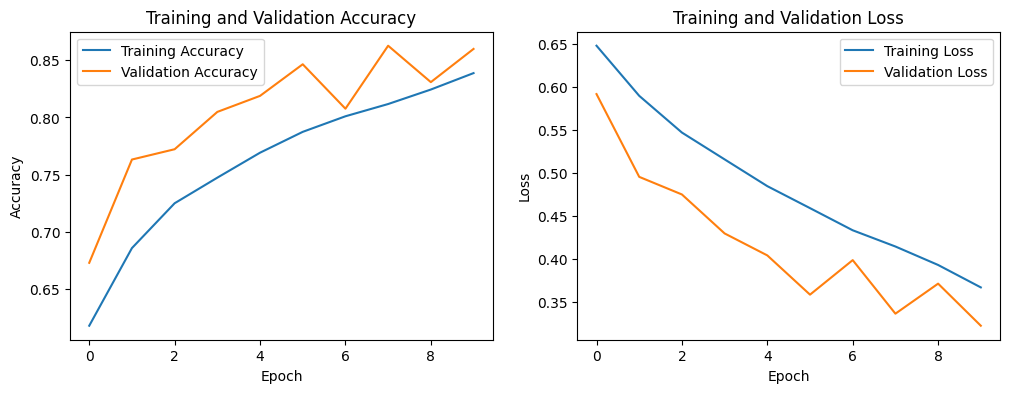

In [5]:
# ## 5. Model Testing and Evaluation

# Evaluate the model on the test set and display various metrics.

print("\n--- Model Evaluation ---")
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Get predictions for the test set
Y_pred = model.predict(test_generator)

# Convert predictions to class labels
if NUM_CLASSES > 2:
    y_pred_classes = np.argmax(Y_pred, axis=1)
    y_true_classes = test_generator.classes
else:
    y_pred_classes = (Y_pred > 0.5).astype(int).flatten()
    y_true_classes = test_generator.classes

# Get true labels
true_labels = test_generator.classes
# Map true labels to class names for report
true_labels_mapped = [class_names[label] for label in true_labels]
predicted_labels_mapped = [class_names[label] for label in y_pred_classes]


# Classification Report
print("\n--- Classification Report ---")
print(classification_report(true_labels_mapped, predicted_labels_mapped, target_names=class_names))

# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(true_labels_mapped, predicted_labels_mapped, labels=class_names)
print(cm)

# Plotting training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
# ## 6. Model Saving

# Save the trained model for later use in the API.
MODEL_PATH = '../models/image_classifier_model.h5'
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
model.save(MODEL_PATH)
print(f"\nModel saved to: {MODEL_PATH}")


Model saved to: ../models/image_classifier_model.h5


In [7]:
# --- Image Preprocessing Utility Function ---
from tensorflow.keras.preprocessing import image

def preprocess_single_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img) / 255.0  # normalize
    return np.expand_dims(img_array, axis=0)  # shape: (1, IMG_HEIGHT, IMG_WIDTH, 3)


Model loaded from: ../models/image_classifier_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Prediction for 9.jpg raw output: [[0.06328433]]
Predicted class for 9.jpg: cats with confidence 0.94


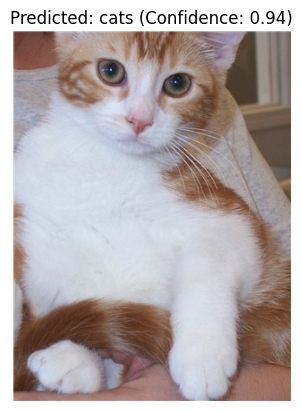

In [8]:
# ## 7. Example Prediction (using the saved model)

# Load the model
loaded_model = load_model(MODEL_PATH)
print(f"\nModel loaded from: {MODEL_PATH}")

# --- START OF CHANGES ---

# Define a path to a real image from your test set
# IMPORTANT: Replace 'path/to/your/real_test_image.jpg' with an actual path
# For example: '../data/test/cats/cat_test_001.jpg' or '../data/test/dogs/dog_test_001.jpg'
# Make sure this image file actually exists in your data/test directory!
real_image_path = '../data/test/cats/9.jpg'

if not os.path.exists(real_image_path):
    print(f"Error: Real image not found at {real_image_path}. Please update the path.")
else:
    # Preprocess the real image
    preprocessed_real_image = preprocess_single_image(real_image_path)

    # Make a prediction on the real image
    real_prediction = loaded_model.predict(preprocessed_real_image)

    print(f"Prediction for {os.path.basename(real_image_path)} raw output: {real_prediction}")

    # Determine predicted class and confidence
    if NUM_CLASSES > 2:  # Multi-class classification
        predicted_class_index = np.argmax(real_prediction, axis=1)[0]
        confidence = np.max(real_prediction)
    else:  # Binary classification
        predicted_class_index = (real_prediction > 0.5).astype(int)[0][0]
        confidence = real_prediction[0][0] if predicted_class_index == 1 else (1 - real_prediction[0][0])

    predicted_class_name = class_names[predicted_class_index]

    print(f"Predicted class for {os.path.basename(real_image_path)}: {predicted_class_name} with confidence {confidence:.2f}")

    # Display the image (optional, but good for visualization)
    try:
        img_display = Image.open(real_image_path)
        plt.imshow(img_display)
        plt.title(f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error displaying image: {e}")